In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%matplotlib inline
import numpy as np
from scipy import ndimage
from matplotlib.image import imsave
import random
from matplotlib import pyplot as plt

import keras
import keras.backend as K
from keras import models
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras import metrics

from keras.layers import Layer
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Activation,Reshape
from keras.layers.convolutional import Convolution2D
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [0]:
class MaxPoolingWithArgmax2D(Layer):
    def __init__(self,pool_size = (2,2),strides = (2,2),padding = 'same',**kwargs):
        super(MaxPoolingWithArgmax2D,self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self,inputs,**kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1,pool_size[0],pool_size[1],1]
            padding = padding.upper()
            strides = [1,strides[0],strides[1],1]
            output, argmax = K.tf.nn.max_pool_with_argmax(
                    inputs,ksize = ksize,strides = strides,padding = padding)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                    K.backend(),type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax,K.floatx())
        return [output,argmax]

    def compute_output_shape(self,input_shape):
        ratio = (1,2,2,1)
        output_shape = [dim//ratio[idx] if dim is not None else None
                for idx,dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape,output_shape]

    def compute_mask(self,inputs,mask = None):
        return 2*[None]

class MaxUnpooling2D(Layer):
    def __init__(self,size = (2,2),**kwargs):
        super(MaxUnpooling2D,self).__init__(**kwargs)
        self.size = size

    def call(self,inputs,output_shape = None):
        updates,mask = inputs[0],inputs[1]
        with K.tf.variable_scope(self.name):
            mask = K.cast(mask,'int32')
            input_shape = K.tf.shape(updates,out_type = 'int32')
            #  calculation new shape
            if output_shape is None:
                output_shape = (input_shape[0],input_shape[1]*self.size[0],
                        input_shape[2]*self.size[1],input_shape[3])
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask,dtype = 'int32')
            batch_shape = K.concatenate([[input_shape[0]],[1],[1],[1]],axis = 0)
            batch_range = K.reshape(K.tf.range(output_shape[0],
                                   dtype = 'int32'),shape = batch_shape)
            b = one_like_mask*batch_range
            y = mask//(output_shape[2]*output_shape[3])
            x = (mask//output_shape[3])%output_shape[2]
            feature_range = K.tf.range(output_shape[3],dtype = 'int32')
            f = one_like_mask*feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = K.tf.size(updates)
            indices = K.transpose(K.reshape(K.stack([b,y,x,f]),[4,updates_size]))
            values = K.reshape(updates,[updates_size])
            ret = K.tf.scatter_nd(indices,values,output_shape)
            return ret

    def compute_output_shape(self,input_shape):
        mask_shape = input_shape[1]
        return (mask_shape[0],mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],mask_shape[3])

In [0]:
def segnet(input_shape,n_labels,kernel,pool_size,output_mode):
    # encoder
    inputs = Input(shape = input_shape)

    conv_1 = Convolution2D(64,(kernel,kernel),padding = "same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64,(kernel,kernel),padding = "same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)

    conv_3 = Convolution2D(128,(kernel,kernel),padding = "same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128,(kernel,kernel),padding = "same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)

    conv_5 = Convolution2D(256,(kernel,kernel),padding = "same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256,(kernel,kernel),padding = "same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256,(kernel,kernel),padding = "same")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_7)

    conv_8 = Convolution2D(512,(kernel,kernel),padding = "same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(512,(kernel,kernel),padding = "same")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(512,(kernel,kernel),padding = "same")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_10)

    conv_11 = Convolution2D(512,(kernel,kernel),padding = "same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(512,(kernel,kernel),padding = "same")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(512,(kernel,kernel),padding = "same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_13)
    print("Build enceder done..")

    # decoder

    unpool_1 = MaxUnpooling2D(pool_size)([pool_5,mask_5])

    conv_14 = Convolution2D(512,(kernel,kernel),padding = "same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(512,(kernel,kernel),padding = "same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(512,(kernel,kernel),padding = "same")(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = MaxUnpooling2D(pool_size)([conv_16,mask_4])

    conv_17 = Convolution2D(512,(kernel,kernel),padding = "same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(512,(kernel,kernel),padding = "same")(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(256,(kernel,kernel),padding = "same")(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19,mask_3])

    conv_20 = Convolution2D(256,(kernel, kernel),padding = "same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(256,(kernel, kernel),padding = "same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(128,(kernel, kernel),padding = "same")(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = MaxUnpooling2D(pool_size)([conv_22,mask_2])

    conv_23 = Convolution2D(128,(kernel, kernel),padding = "same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64,(kernel, kernel),padding = "same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24,mask_1])

    conv_25 = Convolution2D(64,(kernel, kernel),padding = "same")(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(n_labels,(1,1),padding = "valid")(conv_25)
    conv_26 = BatchNormalization()(conv_26)
    conv_26 = Reshape(
            (input_shape[0]*input_shape[1],n_labels),
            input_shape = (input_shape[0],input_shape[1],n_labels))(conv_26)

    outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")

    model = Model(inputs = inputs,outputs=outputs,name = "SegNet")

    return model

In [0]:
def show_img(img):
    fig = plt.figure()
    ax2 = fig.add_subplot(111)
    ax2.imshow(img,cmap='gray')
    plt.show()

def show_result(img):
    img = img.reshape((img_h,img_w,-1))
    img = np.argmax(img,axis = -1)
    show_img(img)

In [0]:
img = np.fromfile('gdrive/My Drive/Python/SegNet/data/img_float64',dtype = 'float64')
label = np.fromfile('gdrive/My Drive/Python/SegNet/data/label_uint8',dtype = 'uint8')
test = np.fromfile('gdrive/My Drive/Python/SegNet/data/test_float64',dtype = 'float64')

In [0]:
img_h = 256
img_w = 256

train_img = img.reshape(-1,img_h,img_w,1)
test_img = test.reshape(-1,img_h,img_w,1)

In [0]:
train_label = label.reshape(-1,img_h*img_w,1)
train_label = to_categorical(train_label)

In [9]:
print(train_img.shape,train_img.dtype)
print(train_label.shape,train_label.dtype)
print(test_img.shape,test_img.dtype)

(2292, 256, 256, 1) float64
(2292, 65536, 2) float32
(200, 256, 256, 1) float64


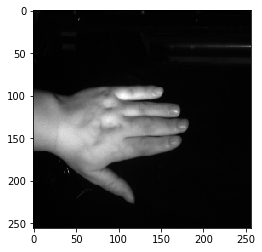

In [10]:
show_img(test_img[0].reshape(256,256))

In [0]:
def save_img(img,path):
    result = img.reshape((img_h,img_w,-1))
    result = np.argmax(result,axis = -1)
    result = ndimage.zoom(result,(480/img_h,640/img_w))
    imsave(path,result,cmap = 'gray')

In [0]:
def dice(gt,pd):
    hits = K.sum(K.abs(K.round(pd)-gt))
    return hits/(img_h*img_w)

In [13]:
'''
with open('gdrive/My Drive/Python/SegNet/model_5l.json') as model_file:
    autoencoder = models.model_from_json(model_file.read())
'''
autoencoder = segnet((256,256,1),2,3, (2,2),"softmax")
#autoencoder.load_weights('gdrive/My Drive/Python/SegNet/model_5l_v2_ADAM_weight_ep10.hdf5')

#optimizer = SGD(lr = 0.001,momentum = 0.9,decay = 0.0005,nesterov = False)
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(loss = 'categorical_crossentropy',optimizer = "adadelta",metrics = ['accuracy',dice])

Instructions for updating:
Colocations handled automatically by placer.
Build enceder done..
Build decoder done..


In [14]:
nb_epoch = 5
batch_size = 16
history = autoencoder.fit(train_img,train_label,batch_size = batch_size,
                          shuffle = True,epochs = nb_epoch,verbose = 1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/5
2292/2292 [==============================] - 302s 132ms/step - loss: 0.4679 - acc: 0.9265 - dice: 2.3508
Epoch 2/5
2292/2292 [==============================] - 286s 125ms/step - loss: 0.3090 - acc: 0.9700 - dice: 0.9575
Epoch 3/5
2292/2292 [==============================] - 282s 123ms/step - loss: 0.2220 - acc: 0.9776 - dice: 0.7152
Epoch 4/5
2292/2292 [==============================] - 282s 123ms/step - loss: 0.1637 - acc: 0.9815 - dice: 0.5929
Epoch 5/5
2292/2292 [==============================] - 281s 123ms/step - loss: 0.1237 - acc: 0.9839 - dice: 0.5157


In [15]:
output = autoencoder.predict(test_img,verbose = 1)
output = output.reshape((output.shape[0],img_h,img_w,-1))
for i in range(200):
    save_img(output[i],'gdrive/My Drive/Python/SegNet/results/model_5l_v2_adadelta_weight_ep5/'+str(i)+'.png')

200/200 [==============================] - 19s 93ms/step


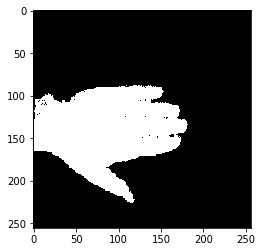

In [16]:
show_result(output[0])

In [0]:
autoencoder.save_weights('gdrive/My Drive/Python/SegNet/results/model_5l_v2_ADAM_weight_ep5/model_5l_v2_ADAM_weight_ep5.hdf5')

In [14]:
print(autoencoder.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [13]:
autoencoder = segnet((256,256,1),2,3, (2,2),"softmax")
#autoencoder.load_weights('gdrive/My Drive/Python/SegNet/model_5l_v2_ADAM_weight_ep10.hdf5')

#optimizer = SGD(lr = 0.001,momentum = 0.9,decay = 0.0005,nesterov = False)
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(loss = 'categorical_crossentropy',optimizer = "adadelta",metrics = ['accuracy',dice])

nb_epoch = 10
batch_size = 16
history = autoencoder.fit(train_img,train_label,batch_size = batch_size,
                          shuffle = True,epochs = nb_epoch,verbose = 1)

output = autoencoder.predict(test_img,verbose = 1)
output = output.reshape((output.shape[0],img_h,img_w,-1))
for i in range(200):
    save_img(output[i],'gdrive/My Drive/Python/SegNet/results/model_5l_v2_adadelta_weight_ep10/'+str(i)+'.png')

autoencoder.save_weights('gdrive/My Drive/Python/SegNet/results/model_5l_v2_adadelta_weight_ep10/model_5l_v2_adadelta_weight_ep10.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Build enceder done..
Build decoder done..
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
2292/2292 [==============================] - 198s 87ms/step - loss: 0.4900 - acc: 0.9015 - dice: 3.1488
Epoch 2/10
2292/2292 [==============================] - 182s 80ms/step - loss: 0.3148 - acc: 0.9685 - dice: 1.0059
Epoch 3/10
2292/2292 [==============================] - 182s 79ms/step - loss: 0.2289 - acc: 0.9760 - dice: 0.7688
Epoch 4/10
2292/2292 [==============================] - 183s 80ms/step - loss: 0.1662 - acc: 0.9815 - dice: 0.5916
Epoch 5/10
2292/2292 [==============================] - 182s 79ms/step - loss: 0.1271 - acc: 0.9831 - dice: 0.5380
Epoch 6/10
2292/2292 [==============================] - 183s 80ms/step - loss: 0.1049 - acc: 0.9828 - dice: 0.5493
Epoch 7/10
2292/2292 [==============================] - 182s 79ms/step

In [14]:
autoencoder = segnet((256,256,1),2,3, (2,2),"softmax")
#autoencoder.load_weights('gdrive/My Drive/Python/SegNet/model_5l_v2_ADAM_weight_ep10.hdf5')

#optimizer = SGD(lr = 0.001,momentum = 0.9,decay = 0.0005,nesterov = False)
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(loss = 'categorical_crossentropy',optimizer = optimizer,metrics = ['accuracy',dice])

nb_epoch = 5
batch_size = 16
history = autoencoder.fit(train_img,train_label,batch_size = batch_size,
                          shuffle = True,epochs = nb_epoch,verbose = 1)

output = autoencoder.predict(test_img,verbose = 1)
output = output.reshape((output.shape[0],img_h,img_w,-1))
for i in range(200):
    save_img(output[i],'gdrive/My Drive/Python/SegNet/results/model_5l_v2_ADAM_weight_ep5/'+str(i)+'.png')

autoencoder.save_weights('gdrive/My Drive/Python/SegNet/results/model_5l_v2_ADAM_weight_ep5/model_5l_v2_ADAM_weight_ep5.hdf5')

Build enceder done..
Build decoder done..
Epoch 1/5
2292/2292 [==============================] - 189s 82ms/step - loss: 0.4775 - acc: 0.9398 - dice: 1.9240
Epoch 2/5
2292/2292 [==============================] - 183s 80ms/step - loss: 0.3496 - acc: 0.9617 - dice: 1.2255
Epoch 3/5
2292/2292 [==============================] - 183s 80ms/step - loss: 0.2799 - acc: 0.9691 - dice: 0.9878
Epoch 4/5
2292/2292 [==============================] - 183s 80ms/step - loss: 0.2247 - acc: 0.9753 - dice: 0.7896
Epoch 5/5
200/200 [==============================] - 11s 53ms/step


In [15]:
autoencoder = segnet((256,256,1),2,3, (2,2),"softmax")
#autoencoder.load_weights('gdrive/My Drive/Python/SegNet/model_5l_v2_ADAM_weight_ep10.hdf5')

#optimizer = SGD(lr = 0.001,momentum = 0.9,decay = 0.0005,nesterov = False)
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(loss = 'categorical_crossentropy',optimizer = optimizer,metrics = ['accuracy',dice])

nb_epoch = 10
batch_size = 16
history = autoencoder.fit(train_img,train_label,batch_size = batch_size,
                          shuffle = True,epochs = nb_epoch,verbose = 1)

output = autoencoder.predict(test_img,verbose = 1)
output = output.reshape((output.shape[0],img_h,img_w,-1))
for i in range(200):
    save_img(output[i],'gdrive/My Drive/Python/SegNet/results/model_5l_v2_ADAM_weight_ep10/'+str(i)+'.png')

autoencoder.save_weights('gdrive/My Drive/Python/SegNet/results/model_5l_v2_ADAM_weight_ep10/model_5l_v2_ADAM_weight_ep10.hdf5')

Build enceder done..
Build decoder done..
Epoch 1/10
2292/2292 [==============================] - 190s 83ms/step - loss: 0.4758 - acc: 0.9395 - dice: 1.9342
Epoch 2/10
2292/2292 [==============================] - 183s 80ms/step - loss: 0.3489 - acc: 0.9631 - dice: 1.1805
Epoch 3/10
2292/2292 [==============================] - 183s 80ms/step - loss: 0.2817 - acc: 0.9696 - dice: 0.9728
Epoch 4/10
2292/2292 [==============================] - 183s 80ms/step - loss: 0.2286 - acc: 0.9739 - dice: 0.8341
Epoch 5/10
2292/2292 [==============================] - 182s 80ms/step - loss: 0.1924 - acc: 0.9767 - dice: 0.7451
Epoch 6/10
2292/2292 [==============================] - 183s 80ms/step - loss: 0.1581 - acc: 0.9808 - dice: 0.6124
Epoch 7/10
2292/2292 [==============================] - 183s 80ms/step - loss: 0.1393 - acc: 0.9814 - dice: 0.5933
Epoch 8/10
2292/2292 [==============================] - 182s 79ms/step - loss: 0.1224 - acc: 0.9825 - dice: 0.5607
Epoch 9/10
2292/2292 [================